# AAut lab question 1 part 1
### Linear regression with outliers

 Import libraries

# Initial steps
Load libraries, load data, visual representations

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, RANSACRegressor
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_squared_error

Load training data

In [4]:
# Importing the datasets
dataX = np.load('X_train.npy')
dataY = np.load('Y_train.npy')
testX = np.load('X_test.npy')

Plot the data for visual representation

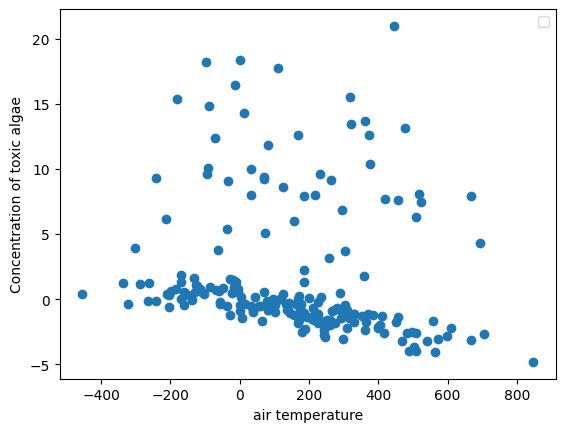

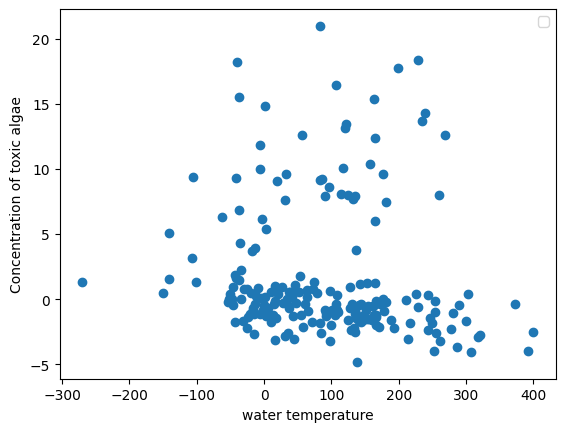

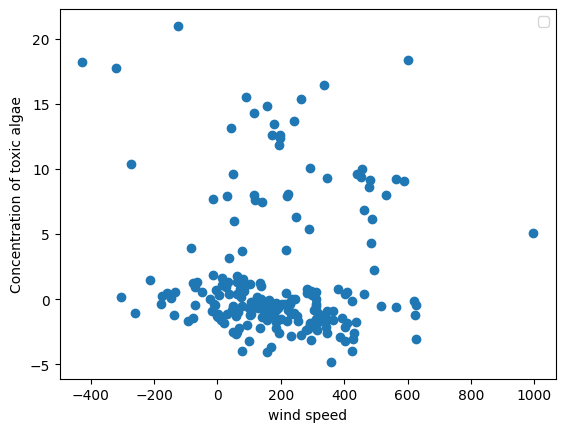

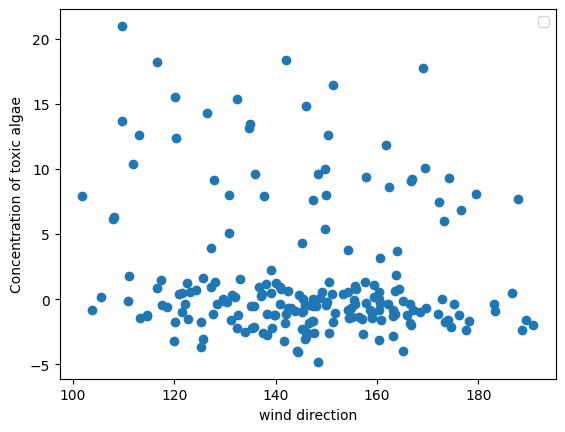

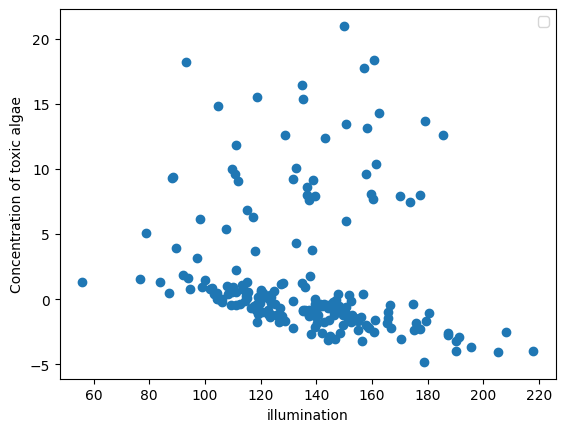

In [5]:
parameters = np.array(["air temperature", "water temperature", "wind speed", "wind direction", "illumination"])
for i in range(5):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.legend()
    plt.plot()
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")

# Important functions

Calculate SSE

In [6]:
def calculate_SSE(MSE, N):
  # Calculate the sum of squared errors
  SSE = MSE * N 
  return SSE

Create linear regression model

In [7]:
def create_model_LinearRegression(X, Y):
    # Create a linear regression model
    model = LinearRegression()
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create Lasso model

In [8]:
def create_model_Lasso(X, Y):
    # Create a Lasso model
    model = LassoCV()
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create Ridge model

In [9]:
def create_model_Ridge(X, Y):
    # Create a Ridge model
    model = RidgeCV()
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create RANSAC model

In [10]:
def create_model_RANSACRegressor(X, Y):
    # Create a RANSACRegressor model
    model = RANSACRegressor()
    # Fit the model to the data
    model.fit(X, Y)
    return model

## Removal of outliers
Removes points with the highest z-score, meaning they are the furthest away from the mean

In [11]:
def remove_outliers_x_axis(X):
    # Calculate the mean and standard deviation of each column
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    
    # Calculate the z-scores for each value in X
    z_scores = np.abs((X - mean) / std_dev)
    
    # Find the index of the maximum z-score
    max_z_score_index = np.unravel_index(np.argmax(z_scores, axis=None), z_scores.shape)[0]
    
    return max_z_score_index

#### Predict a linear regression and remove the point with the highest mse
Comment Break and uncomment remove_outliers_x_axis to also remove outliers from x

In [12]:
def remove_outliers(X, Y):
    num_points_to_remove = int(0.25 * len(Y)) # Remove 25% of the data because of human error
    for _ in range(num_points_to_remove):
        model = LinearRegression()
        model.fit(X, Y)
        predictions = model.predict(X)

        mse = (Y - predictions) ** 2
        
        max_mse_index = np.argmax(mse)
        if mse[max_mse_index] < 5:
            max_mse_index = remove_outliers_x_axis(X)
            # break

        X = np.delete(X, max_mse_index, axis=0)
        Y = np.delete(Y, max_mse_index, axis=0)
    return X, Y

## Removal of redundant features
Predict a linear regression and see if without the feature, it performs better

In [13]:
def remove_features(X, Y):
    features_to_remove = []
    model = create_model_LinearRegression(X, Y)
    cv_score = cross_validate(model, X, Y, cv=10, scoring=('neg_mean_squared_error', 'r2'), return_train_score = True)
      
    MSE_baseline = abs(cv_score['test_neg_mean_squared_error'].mean())

    for dim in range(dataX.shape[1]):
        X_new = np.delete(X, dim, axis=1)
        model = create_model_LinearRegression(X_new, Y)
        cv_score = cross_validate(model, X_new, Y, cv=10, scoring=('neg_mean_squared_error', 'r2'), return_train_score = True)
        MSE = abs(cv_score['test_neg_mean_squared_error'].mean())
        if MSE < MSE_baseline:
            print("Removing feature", parameters[dim], "decreases the MSE from", MSE_baseline, "to", MSE)
            MSE_baseline = MSE
            features_to_remove.append(dim)
            
    new_X = np.delete(X, features_to_remove, axis=1)
    return new_X

# Experiment the models

## Remove outliers from y and x axis

In [14]:
dataX_no_outliers, dataY_no_outliers = remove_outliers(dataX, dataY)

## Remove redundant features

In [15]:
dataX_removed_features = remove_features(dataX_no_outliers, dataY_no_outliers)

Removing feature water temperature decreases the MSE from 0.024209340876128384 to 0.024079857964101108


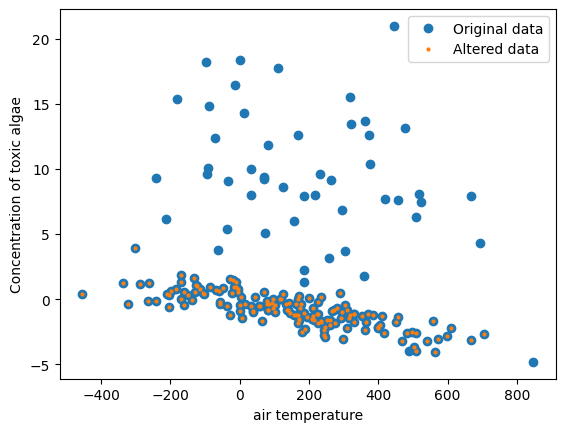

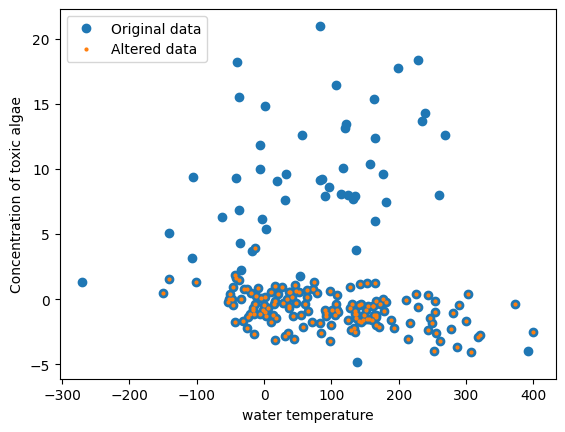

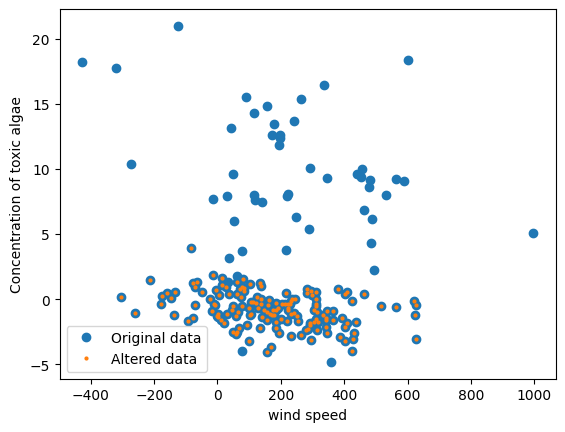

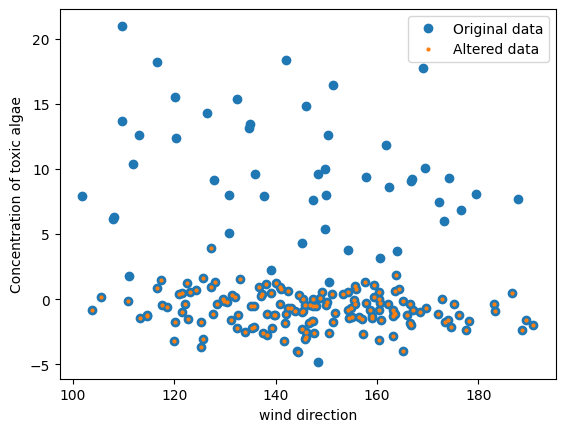

In [16]:
for i in range(dataX_removed_features.shape[1]):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.plot(dataX_no_outliers[:,i], dataY_no_outliers, 'o', markersize=2)
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")
    plt.legend(["Original data", "Altered data"])

### Create and predict
dataX_no_outliers to experiment with NO removed features
dataX_removed_features to experiment with removed features

In [17]:
# Create the models
model_LinearRegression = create_model_LinearRegression(dataX_no_outliers, dataY_no_outliers) # for final submission, best data to train on
model_Lasso = create_model_Lasso(dataX_no_outliers, dataY_no_outliers)
model_Ridge = create_model_Ridge(dataX_no_outliers, dataY_no_outliers)
model_RANSACRegressor = create_model_RANSACRegressor(dataX_no_outliers, dataY_no_outliers)

# Predict the values for the test set
predY_LinearRegression = model_LinearRegression.predict(dataX_no_outliers) # testX for final submission
predY_Lasso = model_Lasso.predict(dataX_no_outliers)
predY_Ridge = model_Ridge.predict(dataX_no_outliers)
predY_RANSACRegressor = model_RANSACRegressor.predict(dataX_no_outliers)

### MSE

In [18]:
# Calculate Mean Squared Error (MSE)
mse_LinearRegression = mean_squared_error(dataY_no_outliers, predY_LinearRegression)
mse_Lasso = mean_squared_error(dataY_no_outliers, predY_Lasso)
mse_Ridge = mean_squared_error(dataY_no_outliers, predY_Ridge)
mse_RANSACRegressor = mean_squared_error(dataY_no_outliers, predY_RANSACRegressor)

### SSE

In [19]:
# Calculate the sum of squared errors
SSE_LinearRegression = calculate_SSE(mse_LinearRegression, len(dataY_no_outliers))
print("SSE Linear Regression: ", SSE_LinearRegression)
SSE_Lasso = calculate_SSE(mse_Lasso, len(dataY_no_outliers))
print("SSE Lasso: ", SSE_Lasso)
SSE_Ridge = calculate_SSE(mse_Ridge, len(dataY_no_outliers))
print("SSE Ridge: ", SSE_Ridge)
SSE_RANSACRegressor = calculate_SSE(mse_RANSACRegressor, len(dataY_no_outliers))
print("SSE RANSACRegressor: ", SSE_RANSACRegressor)

SSE Linear Regression:  3.242678482736773
SSE Lasso:  3.3150834354932077
SSE Ridge:  3.2427539403024768
SSE RANSACRegressor:  3.3802355639819335


2.513869094668215


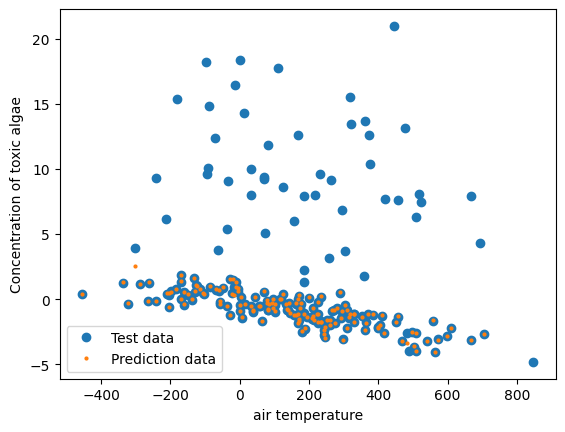

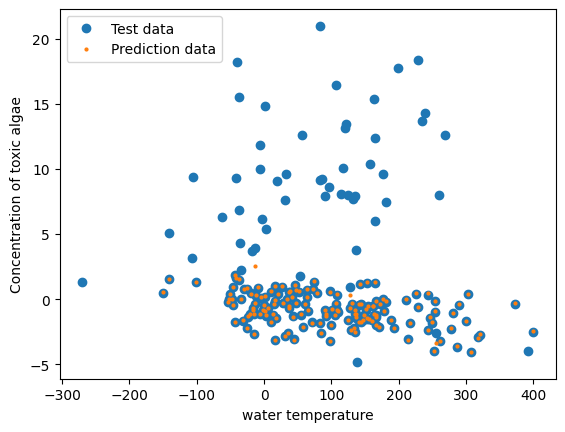

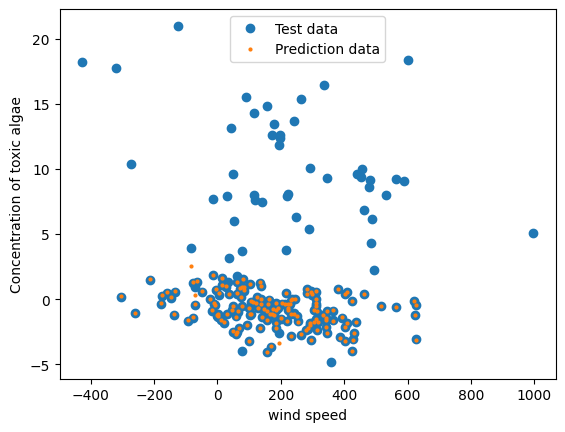

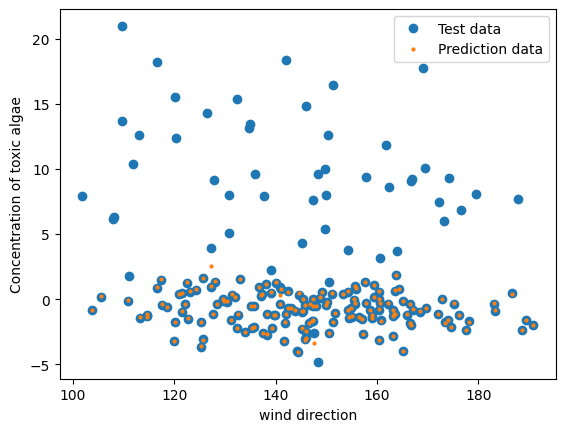

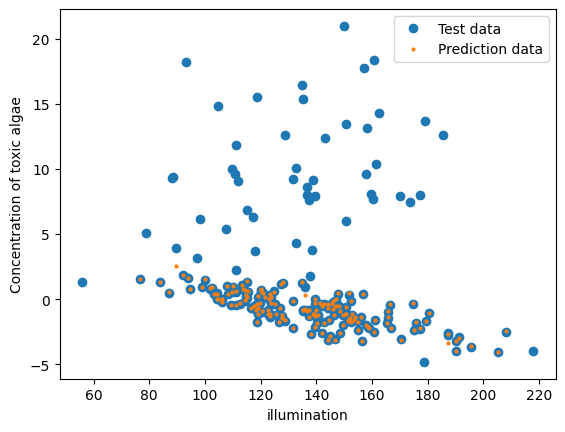

In [23]:
print(model_LinearRegression.intercept_)
for i in range(dataX_no_outliers.shape[1]):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.plot(dataX_no_outliers[:,i], predY_LinearRegression, 'o', markersize=2)
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")
    plt.legend(["Test data", "Prediction data"])